# <u>**Modélisation statistique de la valeur des joueurs de football à partir de leurs performances.**</u>

Par Roman Dupraz-Bardou, Lenny Ouakil et Paul Lemoine Vandermoere

## <u>**Introduction :**</u>

L’évaluation de la valeur des joueurs est une composante clé dans le football moderne. Des plateformes comme Transfermarkt et le CIES fournissent des estimations, mais les clubs cherchent souvent à obtenir des informations plus précises basées sur des performances actualisées. Ce projet vise à construire un modèle qui estime la valeur des joueurs à partir de diverses sources de données sur les performances (open data, scraping, API), puis à comparer les estimations avec celles des plateformes publiques comme Transfermarkt ou le CIES. Pour cela, nous nous concentrerons sur les sept grands championnats européens (Premier League, Ligue 1, Bundesliga, Liga, Serie A, Eredivisie, Liga Portugal) de 2015 à 2024 (championnats écourtés pour cause de pandémie du covid19).

Ainsi, nous nous attendons à observer une corrélation positive entre les performances des joueurs (nombre de buts, de passes décisives, taux de clean sheet...) et leur valeur. Afin d'obtenir un nombre conséquent de données nécessaires à la construction de ce modèle, nous utiliserons des API comme Footballdata.org qui offrent des statistiques détaillées sur les performances des joueurs des sept grands championnats européens (xG, passes clés, interceptions, dribbles, etc.), du scraping depuis des plateformes comme Transfermarkt pour récupérer les valeurs marchandes publiques des joueurs. Il pourrait aussi être intéressant d'intégrer des variables démographiques et/ou caractéristiques (âge, position, durée du contrat) depuis des sources telles que Transfermarkt ou d'autres bases de données disponibles en open data. 

### <u> Sommaire</u>

1. [Installation](#installation)
2. [Obtention des données](#obtention-des-données)
   - [Utilisation d'API](#utilisation-d'api)
   - [Scraping des données de valeur marchande](#scraping-des-données-de-valeur-marchande)
   - [Scraping des données de performances depuis FBref](#scraping-depuis-fbref)
   - [Cartographie](#cartographie)
3. [Statistiques descriptives](#statistiques-descriptives)
4. [Modèle de prédiction](#modèle-de-prédiction)
5. [Conclusion](#conclusion)


<a id='installation'></a>
## <u>**1. Installation** </u>

Afin de construire ce projet, nous avons eu besoin de différentes librairies : 


In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
import webbrowser
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import time
import os
import random
import json
import io
from math import sqrt

<a id='obtention-des-données'></a>
## <u>2. Obtention des données</u>

<a id='utilisation-d'api'></a>
### <u> Utilisation d'API </u>

Dans un premier temps, il nous a paru intéressant d'utiliser des API afin de récupérer des données essentielles sur les joueurs. Il existe différentes API sur le sujet, mais pour des raisons d'efficacité, nous nous focaliserons sur celle fournie par Footballdata.org, dont le plan gratuit permet d'extraire davantage d'informations. Avec cette API, nous avons accès aux informations élémentaires sur les équipes de 10 championnats : Champions League, Primeira Liga, Premier League, Championship, Ligue 1, Eredivisie, Bundesliga, Serie A, Liga ainsi que la Serie A brésilienne. Nous sommes aussi en mesure de fournir des données de l'Euro 2024 et de la Coupe du Monde 2022.

Toutefois, nous nous concentrons ici sur les sept grands championnats européens, dont les ID sont 2021 (Premier League), 2014 (Liga), 2015 (Ligue 1), 2002 (Bundesliga), 2019 (Serie A), 2003 (Eredivisie), 2017 (Primeira Liga). Nous pouvons ainsi accéder à différentes informations sur les équipes qui composent ces championnats. Prenons le cas de la Premier League :

In [2]:
from infoapi import get_teams 

get_teams(2021) 


    Team ID                   Team Name      Short Name     Area  Founded  \
0        57                  Arsenal FC         Arsenal  England     1886   
1        58              Aston Villa FC     Aston Villa  England     1872   
2        61                  Chelsea FC         Chelsea  England     1905   
3        62                  Everton FC         Everton  England     1878   
4        63                   Fulham FC          Fulham  England     1879   
5        64                Liverpool FC       Liverpool  England     1892   
6        65          Manchester City FC        Man City  England     1880   
7        66        Manchester United FC      Man United  England     1878   
8        67         Newcastle United FC       Newcastle  England     1881   
9        73        Tottenham Hotspur FC       Tottenham  England     1882   
10       76  Wolverhampton Wanderers FC   Wolverhampton  England     1877   
11      338           Leicester City FC  Leicester City  England     1884   

Ainsi, grâce à ce data frame nous sommes en capacité d'observer les équipes présentes dans le championnat anglais, mais aussi leur ID. Cela nous permettra ensuite de pouvoir réaliser des recherches plus poussées sur ces équipes afin de nous concentrer sur les joueurs. Regardons plus en détail l'effectif de Manchester United, à l'aide d'un data frame ainsi que d'une représentation par poste: 

                Player Name            Position Date of Birth  \
0               André Onana          Goalkeeper    1996-04-02   
1                Tom Heaton          Goalkeeper    1986-04-15   
2            Altay Bayındır          Goalkeeper    1998-04-14   
3           Godwill Kukonki             Defence    2008-02-06   
4             Jack Fletcher            Midfield    2007-03-19   
5          Jayce Fitzgerald            Midfield    2007-05-09   
6             Manuel Ugarte  Defensive Midfield    2001-04-11   
7               Diogo Dalot          Right-Back    1999-03-18   
8               Jonny Evans         Centre-Back    1988-01-03   
9                 Luke Shaw           Left-Back    1995-07-12   
10              Mason Mount  Attacking Midfield    1999-01-10   
11        Noussair Mazraoui          Right-Back    1997-11-14   
12         Matthijs de Ligt         Centre-Back    1999-08-12   
13           Tyrell Malacia           Left-Back    1999-08-17   
14  Victor Nilsson-Lindel

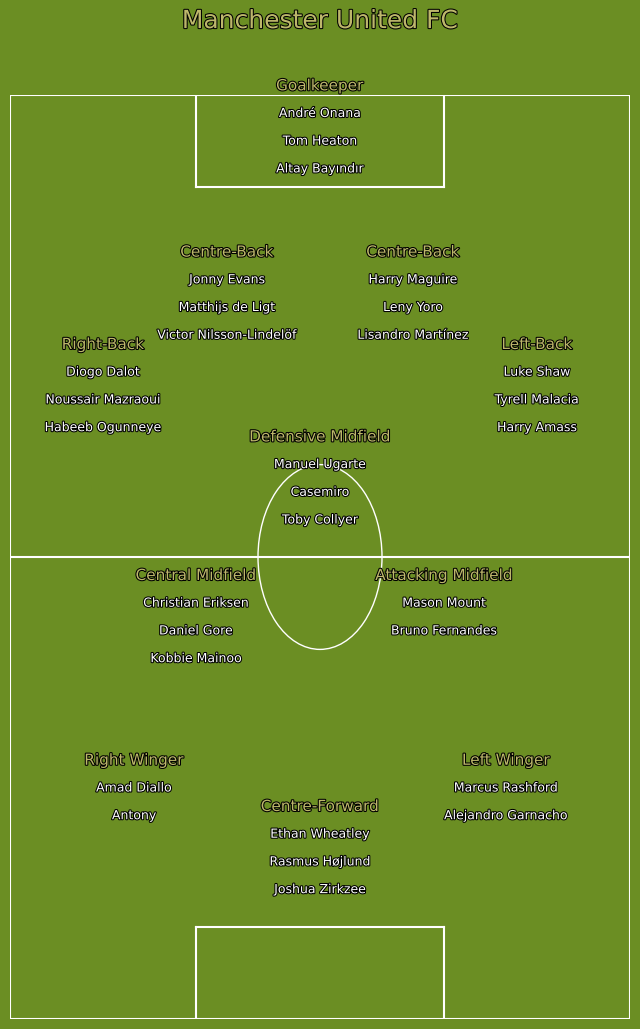

In [3]:
from infoapi import get_players 
from infoapi import draw_team

get_players(66) #crée le data frame de l'effectif
draw_team(66) #crée une représentation de l'effectif par poste 

Nous avons ainsi pu extraire des informations essentielles sur les joueurs de Manchester United. Toutefois, le plan gratuit ne nous permet pas d'accéder à la valeur marchande des joueurs, pourtant centrale dans notre projet. Il sera donc nécessaire d'utiliser d'autres moyens pour l'obtenir. C'est ce que nous allons voir désormais.

<a id='scraping-des-données-de-valeur-marchande'></a>
### <u>Scraping des données de valeur marchande </u>

Le site web de référence en termes d'évaluation de la valeur marchande des joueurs de football est sans contestation possible [**Transfermarkt**](https://www.transfermarkt.com/). Fondé en 2000 par un passionné et supporter du Werder Brême, **Transfermarkt** a rapidement évolué pour devenir une plateforme incontournable dans l'univers du football. Il offre une multitude de données, des statistiques sur les joueurs aux informations sur les transferts, en passant par les performances sur le terrain.

Ainsi, les valeurs **Transfermarkt** reflètent plus l'opinion subjective des fans du ballon rond qu'un réel estimateur objectif permettant de comparer les joueurs entre eux. Il est donc intéressant de trouver des joueurs sous-cotés par rapport à leur valeur **Transfermarkt**. C'est la stratégie suivie par de plus en plus de clubs en Europe comme le Toulouse Football Club ou Liverpool, par exemple.

Malheureusement, le scrapping sur **Transfermarkt** est interdit d'après les conditions d'utilisation. Néanmoins, il semble être toléré et de nombreux utilisateurs de Kaggle scrappent le site régulièrement. Nous avons donc décidé d'utiliser un [**Kaggle**](https://www.kaggle.com/datasets/davidcariboo/player-scores/data?select=clubs.csv) scrappant chaque semaine le site **Transfermarkt** afin de limiter le trafic sur ses serveurs et de réduire ainsi notre responsabilité. Celui-ci contient de nombreuses données essentielles pour notre projet comme les transferts et les valeurs marchandes des joueurs.


In [4]:
import using_data.getkaggledata as gkd

output_dir = gkd.define_output_directory()
gkd.configure_kaggle()
gkd.download_kaggle_dataset(output_dir)

players_df = gkd.load_csv_data('players.csv', output_dir)
transfers_df = gkd.load_csv_data('transfers.csv', output_dir)
valuations_df = gkd.load_csv_data('player_valuations.csv', output_dir)
clubs_df = gkd.load_csv_data('clubs.csv', output_dir)

Dataset download complete.


Une fois les datasets récupérés et convertis en dataframe, nous pouvons commencer les premiers traitements et analyses. Tout d'abord, nous ne conservons que les transferts pertinents, c'est-à-dire :

- Les transferts avec une valeur de transfert supérieure à 100 000 euros (afin de ne pas prendre en compte les prêts, les fins de contrats ou tout autre transfert non conventionnel).
- Les transferts impliquant des joueurs des sept ligues européennes majeures (Allemagne, Angleterre, Espagne, France, Italie, Pays-Bas et Portugal).
- Les transferts effectués lors des 10 dernières saisons.

In [5]:
relevant_transfers = gkd.filter_relevant_transfers(transfers_df)
top_clubs = gkd.filter_top_clubs(clubs_df)
relevant_transfers = gkd.merge_transfers_with_clubs(relevant_transfers, top_clubs)
relevant_transfers.columns

Index(['player_id', 'transfer_date', 'transfer_season', 'from_club_id',
       'to_club_id', 'from_club_name', 'to_club_name', 'transfer_fee',
       'market_value_in_eur', 'player_name', 'from_domestic_competition_id',
       'to_domestic_competition_id'],
      dtype='object')

Une fois cela fait, il peut être intéressant d'analyser les liens entre les valeurs de transferts (variable 'transfer_fee') et les valeurs marchandes (variable 'market_value_in_eur').

In [6]:
gkd.analyze_value_discrepancy(relevant_transfers, 'transfer_fee', 'market_value_in_eur')

gkd.compute_correlations(relevant_transfers['transfer_fee'], relevant_transfers['market_value_in_eur'])

Analysis for columns: transfer_fee vs market_value_in_eur
Mean Difference: 1184557.7139332648
L1 Distance: 4445579.815038199
L2 Distance: 405884709.75019497


{'Pearson_correlation': 0.8581637049323034,
 'Pearson_p_value': 0.0,
 'Spearman_correlation': 0.844521856174061,
 'Spearman_p_value': 0.0}

Les résultats montrent une forte corrélation positive entre les valeurs des transferts et les valeurs marchandes des joueurs, avec un coefficient de corrélation de Pearson de 0.86 et un coefficient de corrélation de Spearman de 0.84. Cela indique que les valeurs de transfert augmentent généralement de manière proportionnelle aux valeurs marchandes, et cette relation est à la fois linéaire et monotone. De plus, la différence moyenne d'environ 1 million d'euros entre les valeurs de transfert et les valeurs marchandes suggère une tendance systématique dans les évaluations des joueurs

             club  correlation
190    US Palermo     0.997354
113  RCD Mallorca     0.992700
114         Lazio     0.988471
155       Brescia     0.987089
41      Liverpool     0.982175
              club  correlation
104        FC Metz     0.976700
100     CD Leganés     0.973219
38            Lens     0.968199
127        Swansea     0.957290
97   F. Düsseldorf     0.945095


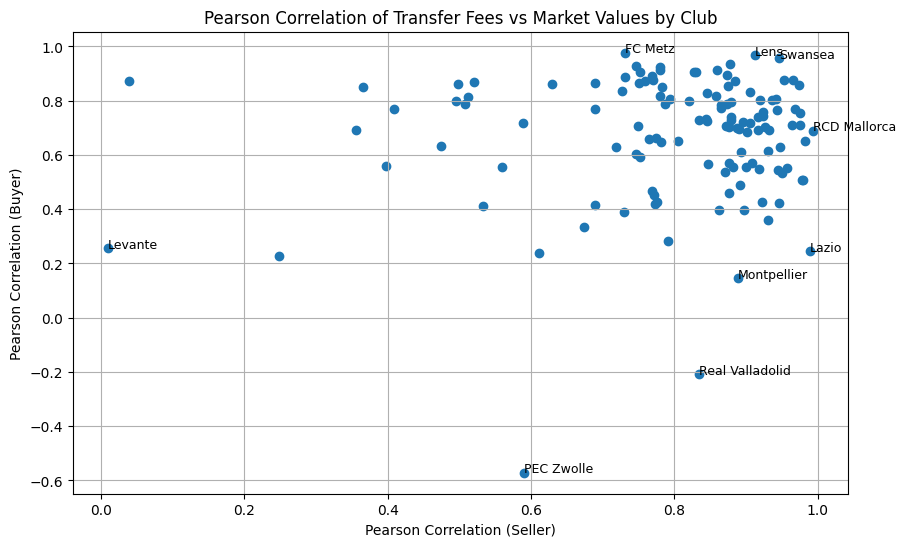

In [7]:
gkd.analyze_club_metrics(relevant_transfers)

Le graphique montre que la majorité des clubs ont une forte corrélation (plus de 0.8) entre les valeurs de transfert sur Transfermarkt et les valeurs de transfert réelles, que ce soit lorsqu'ils vendent ou achètent des joueurs. Cela indique que, pour la plupart des clubs, les valeurs de transfert sur Transfermarkt sont un bon indicateur des valeurs de transfert réelles.

Des clubs comme le RC Lens et Swansea suivent de très près les valeurs de Transfermarkt lors de leurs transactions, avec des corrélations proches de 1. Cela signifie que les valeurs de transfert de ces clubs sont presque parfaitement alignées avec les évaluations de Transfermarkt, tant pour les ventes que pour les achats.

En revanche, certains clubs comme Levante montrent des transactions très décorrélées avec les valeurs de Transfermarkt. Cela pourrait indiquer que Levante utilise des critères différents ou des stratégies spécifiques qui ne sont pas reflétés dans les évaluations de Transfermarkt.

Enfin, un club comme le PEC Zwolle va à l'encontre des tendances de Transfermarkt lorsqu'il achète des joueurs, avec une corrélation de Pearson en tant qu'acheteur de -0.6. Cela suggère que PEC Zwolle pourrait acheter des joueurs à des valeurs significativement différentes de celles estimées par Transfermarkt, peut-être en raison d'une tendance à flairer les 'bons coups' sur le marché des transferts.

<a id='scraping-depuis-fbref'></a>
### <u> Scraping des données de performances depuis FBref </u>

Dans le but de diversifier nos sources de données sur les joueurs, nous nous sommes aussi concentré sur le scraping des tableaux de données présents dans le site [FBref.com](https://fbref.com/en/). FBref est un site spécialisé dans les statistiques et les analyses détaillées de football et offre des données complètes sur les joueurs, les équipes et les compétitions du monde entier. Comme précisé précédemment, nous nous sommes accordés pour restreindre l'étude sur les 7 grands championnats européens (pour rappel : English Premier League , Spanish LaLiga, French Ligue 1, German Bundesliga, Italian Serie A, Dutch Eredivisie, Portuguese Primeira Liga). Le but est de récupérer tous les joueurs ayant joué dans un des 7 championnats au moins une saison durant les 10 dernières saisons (de 2015-2016 à 2024-2025) et de scraper leurs statistiques au moins depuis 2010-2011. Nous scraperons d'abord les joueurs d'Eredivisie puis de Primeira Liga et enfin le top5 en une seule fois.




Expliquons d'abord le procédé pour le scraping des joueurs d'Eredivisie. 
Nous commençons par coder une fonction qui nous donne tous les urls des clubs présents dans la ligue à une saison donnée. Pour cela, il faut accéder à la table qui contient tous les clubs de la ligue à une saison donnée dont l'id est 'results{season}231_overall' et récupérer l'url de chaque club présent dans la table : 

In [8]:
def get_club_urls(league_url, season):
    '''Get URLs for all clubs in the league for a specific season'''
    HEADERS = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    response = requests.get(league_url, headers=HEADERS)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Replace dynamic ID based on the season
    table_id = f'results{season}231_overall'
    clubs_table = soup.find('table', id=table_id)
    
    if not clubs_table:
        raise ValueError(f'Could not find the clubs table with ID: {table_id}')

    club_links = []
    for row in clubs_table.find_all('tr'):
        first_col = row.find('td', {'data-stat': 'team'})
        if first_col and first_col.find('a'):
            link0 = 'https://fbref.com' + first_col.find('a')['href']
            club_links.append(link0)
    
    return club_links

Le dictionnaire HEADERS est utilisé pour définir des en-têtes HTTP personnalisés lors de la requête effectuée avec requests.get. Ces en-têtes sont principalement utiles pour éviter d'être bloqué par le serveur.

In [9]:
get_club_urls('https://fbref.com/en/comps/23/2023-2024/2023-2024-Eredivisie-Stats', '2023-2024')

['https://fbref.com/en/squads/e334d850/2023-2024/PSV-Eindhoven-Stats',
 'https://fbref.com/en/squads/fb4ca611/2023-2024/Feyenoord-Stats',
 'https://fbref.com/en/squads/a1f721d3/2023-2024/Twente-Stats',
 'https://fbref.com/en/squads/3986b791/2023-2024/AZ-Alkmaar-Stats',
 'https://fbref.com/en/squads/19c3f8c4/2023-2024/Ajax-Stats',
 'https://fbref.com/en/squads/fc629994/2023-2024/NEC-Nijmegen-Stats',
 'https://fbref.com/en/squads/2a428619/2023-2024/Utrecht-Stats',
 'https://fbref.com/en/squads/146a68ce/2023-2024/Sparta-Rotterdam-Stats',
 'https://fbref.com/en/squads/e33d6108/2023-2024/Go-Ahead-Eagles-Stats',
 'https://fbref.com/en/squads/bd08295c/2023-2024/Fortuna-Sittard-Stats',
 'https://fbref.com/en/squads/193ff7aa/2023-2024/Heerenveen-Stats',
 'https://fbref.com/en/squads/e3db180b/2023-2024/Zwolle-Stats',
 'https://fbref.com/en/squads/2b41acb5/2023-2024/Almere-City-Stats',
 'https://fbref.com/en/squads/c882b88e/2023-2024/Heracles-Almelo-Stats',
 'https://fbref.com/en/squads/bb14adb3/

Ensuite il faut une fonction qui renvoie pour chaque club la liste d'url de chaque joueurs. On récupère la table de joueurs d'id 'stats_standard_23' et on construit les liens pour avoir la page des joueurs sur toutes les compétitions confondues: 

In [10]:
def scrape_club_players(club_url):
    '''Get player links for a specific club'''
    HEADERS = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    time.sleep(random.uniform(3, 4))  # random delay
    
    response = requests.get(club_url, headers=HEADERS)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    players_table = soup.find('table', id='stats_standard_23')
    
    if not players_table:
        print(f'Warning: no players table for {club_url} ')
        return []

    player_links = []
    for row in players_table.find_all('tr'):
        player_cell = row.find('th', {'data-stat': 'player'})
        if player_cell and player_cell.find('a'):
            player_link = player_cell.find('a')['href']
            
            # Build complete URL
            linkbefore = 'https://fbref.com' + player_link
            linkmid = linkbefore.split('/')
            linkmid.insert(6, 'all_comps')
            full_url = '/'.join(linkmid) + '-Stats---All-Competitions'
            
            player_links.append(full_url)
    
    return player_links


On utilise une pause random entre 3 et 4 secondes de pause de manière random pour que le serveur ait plus de mal à détecter le fait que le scraping est automatisé. 

In [11]:
scrape_club_players('https://fbref.com/en/squads/e334d850/2023-2024/PSV-Eindhoven-Stats')

['https://fbref.com/en/players/abb3bb95/all_comps/Luuk-de-Jong-Stats---All-Competitions',
 'https://fbref.com/en/players/8a2248b4/all_comps/Walter-Benitez-Stats---All-Competitions',
 'https://fbref.com/en/players/403f5d20/all_comps/Olivier-Boscagli-Stats---All-Competitions',
 'https://fbref.com/en/players/0caa2fd4/all_comps/Johan-Bakayoko-Stats---All-Competitions',
 'https://fbref.com/en/players/82e9b1bb/all_comps/Jordan-Teze-Stats---All-Competitions',
 'https://fbref.com/en/players/7483d9f9/all_comps/Andre-Ramalho-Stats---All-Competitions',
 'https://fbref.com/en/players/2cfae697/all_comps/Jerdy-Schouten-Stats---All-Competitions',
 'https://fbref.com/en/players/18fae4ac/all_comps/Joey-Veerman-Stats---All-Competitions',
 'https://fbref.com/en/players/5976f83e/all_comps/Sergino-Dest-Stats---All-Competitions',
 'https://fbref.com/en/players/6e44569a/all_comps/Guus-Til-Stats---All-Competitions',
 'https://fbref.com/en/players/a5420709/all_comps/Malik-Tillman-Stats---All-Competitions',
 'h

Et maintenant il nous faut une fonction qui, pour chaque joueur d'un club entré en argument, récupère la table de données pour toutes les saisons plus récentes que 2010-2011. 
Cependant la table du site est une table dont les colonnes sont multiindexées : 

In [12]:
# Example with Luuk de Jong's table

# Get Luuk de Jong's table and convert it into a DataFrame to inspect its columns
HEADERS = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
response = requests.get('https://fbref.com/en/players/abb3bb95/Luuk-de-Jong', headers=HEADERS)
soup = BeautifulSoup(response.text, 'html.parser')
stats_table = soup.find('table', id='stats_standard_dom_lg')
stats_table_html = str(stats_table)
stats_table = pd.read_html(io.StringIO(stats_table_html), header=[0, 1])[0]


print(stats_table.columns)

MultiIndex([( 'Unnamed: 0_level_0',   'Season'),
            ( 'Unnamed: 1_level_0',      'Age'),
            ( 'Unnamed: 2_level_0',    'Squad'),
            ( 'Unnamed: 3_level_0',  'Country'),
            ( 'Unnamed: 4_level_0',     'Comp'),
            ( 'Unnamed: 5_level_0',   'LgRank'),
            ( 'Unnamed: 6_level_0',       'MP'),
            (       'Playing Time',   'Starts'),
            (       'Playing Time',      'Min'),
            (       'Playing Time',      '90s'),
            (        'Performance',      'Gls'),
            (        'Performance',      'Ast'),
            (        'Performance',      'G+A'),
            (        'Performance',     'G-PK'),
            (        'Performance',       'PK'),
            (        'Performance',    'PKatt'),
            (        'Performance',     'CrdY'),
            (        'Performance',     'CrdR'),
            (           'Expected',       'xG'),
            (           'Expected',     'npxG'),
            (       

Il faut alors créer une fonction qui aplatit les colonnes tout en les renommant de manière à ce que le nom de la colonne de l'index le plus haut soit suivi de ' : ' et du nom de la colonne du deuxième index (lorsque le premier index commence par 'Unnamed' , on choisi de garder seulement le nom du deuxième index). Pour donner un exemple : la colonne ('Performance','Gls') devient 'Performance : Gls' et 
('Unnamed: 0_level_0', 'Season') devient 'Season'.

In [13]:
def rename_columns(df):
    new_columns = []
    for col in df.columns:
        # If the 1st index starts with 'Unnamed', the column takes the name of the 2nd index
        if str(col[0]).startswith('Unnamed'):
            new_columns.append(col[1])
        else: # The names of the 1st and 2nd index are combined with ':'
            new_columns.append(f'{col[0]} : {col[1]}')
    
    # Apply the new column names
    df.columns = new_columns
    return df

In [14]:
# Example with Luuk de Jong's table
print(rename_columns(stats_table).columns)


Index(['Season', 'Age', 'Squad', 'Country', 'Comp', 'LgRank', 'MP',
       'Playing Time : Starts', 'Playing Time : Min', 'Playing Time : 90s',
       'Performance : Gls', 'Performance : Ast', 'Performance : G+A',
       'Performance : G-PK', 'Performance : PK', 'Performance : PKatt',
       'Performance : CrdY', 'Performance : CrdR', 'Expected : xG',
       'Expected : npxG', 'Expected : xAG', 'Expected : npxG+xAG',
       'Progression : PrgC', 'Progression : PrgP', 'Progression : PrgR',
       'Per 90 Minutes : Gls', 'Per 90 Minutes : Ast', 'Per 90 Minutes : G+A',
       'Per 90 Minutes : G-PK', 'Per 90 Minutes : G+A-PK',
       'Per 90 Minutes : xG', 'Per 90 Minutes : xAG',
       'Per 90 Minutes : xG+xAG', 'Per 90 Minutes : npxG',
       'Per 90 Minutes : npxG+xAG', 'Matches'],
      dtype='object')


On peut maintenant coder une fonction qui récupère la table du joueur entre 2010-2011 et 2024-2025. 
Sur le FBref, la table à un id qui est égal à 'stats_standard_expanded' ou 'stats_standard_dom_lg' selon les joueurs. On la récupère, on rajoute une colonne 'Player' qui donne le nom du joueur et on applique la fonction précédente pour reshape le dataframe obtenu. 
De plus, pour optimiser notre scraping en temps et en espace, nous avons rajouté un argument 'existing_players' à la fonction  pour ne pas scraper la table d'un joueur si le joueur est déjà dans la liste existing_players. 

In [15]:
def scrape_stats_player(player_url, existing_players):
    '''Get statistics for a specific player if not already in the dataset.'''

    # Get player name and check if it is on the existing_players list
    player_name = player_url.split('/')[-1].replace('-Stats---All-Competitions', '').replace('-', ' ')

    if player_name in existing_players:
        print(f'Skipping {player_name} (already exists in the dataset).')
        return pd.DataFrame()

    HEADERS = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    time.sleep(random.uniform(3, 4)) # random delay

    # Get the stats table 
    try:
        response = requests.get(player_url, headers=HEADERS)
        soup = BeautifulSoup(response.text, 'html.parser')
        stats_table = soup.find('table', id='stats_standard_expanded')
        
        if stats_table is None:
            stats_table = soup.find('table', id='stats_standard_dom_lg')
            
        if stats_table is None:
            print(f'No stats table found for URL: {player_url}')
            return pd.DataFrame()

        # Convert HTML table into DataFrame
        try:
            stats_table_html = str(stats_table)  # Convertir en chaîne
            stats_table = pd.read_html(io.StringIO(stats_table_html), header=[0, 1])[0]
        except ValueError as e:
            print(f'Error reading HTML table for {player_name}: {e}')
            return pd.DataFrame()

        # Create a copy to avoid SettingWithCopyWarning
        stats_table = stats_table.copy()

        # add the player's name
        stats_table.loc[:, ('Unnamed: -1_level_0', 'Player')] = player_name

        # Reorder columns 
        new_order = [('Unnamed: -1_level_0', 'Player')] + list(stats_table.columns[:-1])
        stats_table = stats_table[new_order]

        # Renaming and flattening columns 
        stats_table = rename_columns(stats_table)

        # Keep only season since 2010-2011
        allowed_seasons = ['2010-2011', '2011-2012', '2012-2013', '2013-2014','2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022', 
            '2022-2023', '2023-2024', '2024-2025']
        season_column = 'Season'
        if season_column in stats_table.columns:
            stats_table = stats_table[stats_table[season_column].isin(allowed_seasons)]

        return stats_table
    except Exception as e:
        print(f'Error scraping stats for {player_name}: {e}')
        return pd.DataFrame()

In [16]:
scrape_stats_player('https://fbref.com/en/players/abb3bb95/Luuk-de-Jong', []).head()

,Player,Season,Age,Squad,Country,Comp,LgRank,MP,Playing Time : Starts,Playing Time : Min,...,Per 90 Minutes : Ast,Per 90 Minutes : G+A,Per 90 Minutes : G-PK,Per 90 Minutes : G+A-PK,Per 90 Minutes : xG,Per 90 Minutes : xAG,Per 90 Minutes : xG+xAG,Per 90 Minutes : npxG,Per 90 Minutes : npxG+xAG,Matches
2,Luuk de Jong,2010-2011,19,Twente,nl NED,1. Eredivisie,2nd,32,31,2763,...,0.26,0.65,0.39,0.65,NaN,NaN,NaN,NaN,NaN,Matches
3,Luuk de Jong,2011-2012,20,Twente,nl NED,1. Eredivisie,6th,31,31,2761,...,0.26,1.08,0.78,1.04,NaN,NaN,NaN,NaN,NaN,Matches
4,Luuk de Jong,2012-2013,21,Gladbach,de GER,1. Bundesliga,8th,23,17,1407,...,0.13,0.51,0.38,0.51,NaN,NaN,NaN,NaN,NaN,Matches
5,Luuk de Jong,2013-2014,22,Gladbach,de GER,1. Bundesliga,6th,13,0,85,...,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,Matches
6,Luuk de Jong,2013-2014,22,Newcastle Utd,eng ENG,1. Premier League,10th,12,8,667,...,0.13,0.13,0.00,0.13,NaN,NaN,NaN,NaN,NaN,Matches


In [17]:
scrape_stats_player('https://fbref.com/en/players/abb3bb95/Luuk-de-Jong', ['Luuk de Jong'])

Skipping Luuk de Jong (already exists in the dataset).


""


Reste maintenant à coder une fonction pour appliquer scrape_stats_player fonctions à tous les joueurs des tous les clubs qui ont joué en Eredivisie entre 2015-2016 et 2024-2025. On met en place un système de suivi de progression dans un fichier JSON qui nous permet de reprendre la boucle à un endroit précis si besoin.

In [18]:
CONFIG_FILE = 'scraping_progress_ered.json'

def save_progress(data):
    '''Save scraping progress to a JSON file, including the season.'''
    with open(CONFIG_FILE, 'w') as f:
        json.dump(data, f)

        

def load_progress():
    '''Load previous scraping progress.'''
    try:
        with open(CONFIG_FILE, 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        return {'season': None, 'last_club': None, 'last_player': None}




def get_resumption_points(progress, season, club_urls, club_url=None, player_urls=None):
    '''
    Determine resumption points for season, club, and player based on progress.
    Returns a tuple: start_club_index, start_player_index
    '''
    # Find starting club index
    start_club_index = 0
    if progress['season'] == season and progress['last_club']:
        normalized_last_club = progress['last_club'].split('/squads/')[1].split('/')[0]
        for i, url in enumerate(club_urls):
            if f'/squads/{normalized_last_club}/' in url:
                start_club_index = i
                break

    # Find starting player index if applicable
    start_player_index = 0
    if player_urls and progress['season'] == season and progress['last_club'] == club_url and progress['last_player']:
        try:
            start_player_index = player_urls.index(progress['last_player'])
        except ValueError:
            start_player_index = 0

    return start_club_index, start_player_index




def main(season, all_players_stats, existing_players):
    '''
    Main function to scrape stats for a specific season, resuming from saved progress.
    '''
    ered_url = f'https://fbref.com/en/comps/23/{season}/{season}-Eredivisie-Stats'
    progress = load_progress()

    # Update season if necessary
    if progress.get('season') != season:
        progress = {'season': season, 'last_club': None, 'last_player': None}
        save_progress(progress)

    # Get club URLs
    club_urls = get_club_urls(ered_url, season)
    all_players_stats = pd.DataFrame()

    # Identify resumption point for clubs
    start_club_index, _ = get_resumption_points(progress, season, club_urls)

    # Process each club starting from the resumption index
    for club_url in club_urls[start_club_index:]:
        try:
            print(f'Scraping club: {club_url}')
            player_urls = scrape_club_players(club_url)

            # Identify resumption point for players
            _, start_player_index = get_resumption_points(progress, season, club_urls, club_url, player_urls)

            # Scrape stats for each player starting from the resumption index
            for player_url in player_urls[start_player_index:]:
                print(f'Scraping player: {player_url}')
                player_stats = scrape_stats_player(player_url, existing_players)

                # Append stats to the main DataFrame
                if not player_stats.empty:
                    all_players_stats = pd.concat([all_players_stats, player_stats], ignore_index=True)

                # Save progress after each player
                save_progress({'season': season, 'last_club': club_url, 'last_player': player_url})

        except Exception as e:
            print(f'Error for club {club_url}: {e}')

    print('Scraping terminé.')
    if os.path.exists(CONFIG_FILE):
        os.remove(CONFIG_FILE)

    return all_players_stats

Enfin, il nous reste à créer une fonction qui prend en entrée seulement une saison donnée et enregistre le résultat dans un fichier csv 

In [19]:
def main_with_existing_data(season):
    # Load existing data
    # Get the directory of the current script
    script_dir = os.getcwd()
    # Dynamically construct the path to 'results_csv' in the parent directory
    scraping_data_dir = os.path.join(script_dir, 'scraping_data')
    results_dir = os.path.join(scraping_data_dir, 'results_csv')
    # Construct the full path to the CSV file
    file_path = os.path.join(results_dir, 'players_stats_eredivisie.csv')

    # Check if the file exists
    if not os.path.exists(file_path):
        # If the file doesn't exist, create an empty DataFrame and save it as the CSV
        print(f'{file_path} does not exist. Creating a new empty file.')
        empty_df = pd.DataFrame()  # Create an empty DataFrame
        empty_df.to_csv(file_path, index=False)  # Save it as a CSV file

    # Load existing data
    try:
        existing_data = pd.read_csv(file_path, low_memory=False)
        existing_players = set(existing_data['Player'].unique())
    except FileNotFoundError:
        existing_data = pd.DataFrame()
        existing_players = set()

    # Initialize all_players_stats with existing data
    all_players_stats = existing_data

    # Scrape new data for the given season
    all_players_stats = main(season, all_players_stats, existing_players)

    # Remove duplicates (if necessary)
    if all_players_stats.duplicated(subset=['Player', 'Season']).any():
        all_players_stats = all_players_stats.drop_duplicates(subset=['Player', 'Season'])

    # Save the updated dataset back to the original file
    all_players_stats.to_csv(file_path, index=False)

Et voila, notre fonction est prête à scraper! 

In [20]:
'''seasons_list=['2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022', '2022-2023', '2023-2024', '2024-2025']
for season in seasons_list:
    main_with_existing_data(season)'''

"seasons_list=['2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022', '2022-2023', '2023-2024', '2024-2025']\nfor season in seasons_list:\n    main_with_existing_data(season)"

Les ''' ''' ont été rajoutées puisque le code tourne pendant longtemps et ce n'est pas nécessaire de le faire fonctionner pour la suite puisque les csv sont déjà disponibles dans le git. D'ailleurs voici un aperçu de 'players_stats_eredivisie.csv'

In [21]:
script_dir = os.getcwd()
scraping_data_dir = os.path.join(script_dir, 'scraping_data')
results_dir = os.path.join(scraping_data_dir, 'results_csv')
file_path = os.path.join(results_dir, 'players_stats_eredivisie.csv')


print(file_path)
df = pd.read_csv(file_path, low_memory=False)
df.head()

c:\Users\rorod\ModelingFootballValue\scraping_data\results_csv\players_stats_eredivisie.csv


,Unnamed: 0,Player,Season,Age,Squad,Country,Comp,MP,Playing Time : Starts,Playing Time : Min,...,Per 90 Minutes : xAG,Per 90 Minutes : xG+xAG,Per 90 Minutes : npxG,Per 90 Minutes : npxG+xAG,Matches,Playing Time : MP,LgRank,MP.1,Matches.1,Matches.2
0,0,Ryan Flamingo,2022-2023,19.0,Vitesse,nl NED,1. Eredivisie,33.0,30.0,2683.0,...,0.03,0.13,0.10,0.13,Matches,NaN,NaN,NaN,NaN,NaN
1,1,Ryan Flamingo,2023-2024,20.0,Utrecht,nl NED,1. Eredivisie,32.0,30.0,2759.0,...,0.02,0.11,0.09,0.11,Matches,NaN,NaN,NaN,NaN,NaN
2,2,Ryan Flamingo,2024-2025,21.0,PSV Eindhoven,NaN,1. Champions Lg,6.0,6.0,540.0,...,0.02,0.06,0.04,0.06,Matches,NaN,NaN,NaN,NaN,NaN
3,3,Matteo Dams,2021-2022,17.0,Jong PSV,nl NED,2. Eerste Divisie,1.0,0.0,2.0,...,NaN,NaN,NaN,NaN,Matches,NaN,NaN,NaN,NaN,NaN
4,4,Matteo Dams,2022-2023,18.0,Jong PSV,nl NED,2. Eerste Divisie,12.0,1.0,187.0,...,NaN,NaN,NaN,NaN,Matches,NaN,NaN,NaN,NaN,NaN


On fait exactement la même chose avec quelques légers changements pour la Primeira Liga : 
- dans get_club_urls : table_id = f'results{season}321_overall' 
- dans scrape_club_players : players_table = soup.find('table', id='stats_standard_32')
- dans main : primeira_url = f'https://fbref.com/en/comps/32/{season}/{season}-Primeira-Liga-Stats'
- dans main_with_existing_data : file_path = os.path.join(results_dir, 'players_stats_primeiraliga.csv')

De même pour scraper les données des 5 grands championnats :
- dans get_club_urls : clubs_table = soup.find('table', id='big5_table')
- dans scrape_club_players : 'players_table = soup.find('table', id='stats_standard_23')' devient 
    'for x in [20, 13, 12, 9, 11]:
        if soup.find('table', id=f'stats_standard_{x}') is not None:
            players_table = soup.find('table', id=f'stats_standard_{x}')'
- dans main : top5_url = f'https://fbref.com/en/comps/Big5/{season}/{season}-Big-5-European-Leagues-Stats'
- dans main_with_existing_data : file_path = os.path.join(results_dir, 'players_stats_top5.csv')

Enfin il nous reste à concaténer les csv en éliminant les doublons ! 

In [22]:
script_dir = os.getcwd()
scraping_data_dir = os.path.join(script_dir, 'scraping_data')
results_dir = os.path.join(scraping_data_dir, 'results_csv')


top5_path = os.path.join(results_dir, 'players_stats_top5.csv')
primeira_path = os.path.join(results_dir, 'players_stats_primeiraliga.csv')
eredivisie_path = os.path.join(results_dir, 'players_stats_eredivisie.csv')


top5= pd.read_csv(top5_path, low_memory=False)
primeira=pd.read_csv(primeira_path, low_memory=False)
eredivisie=pd.read_csv(eredivisie_path, low_memory=False)


# Keep common columns
common_columns = primeira.columns.intersection(top5.columns)


primeira_common = primeira[common_columns]
eredivisie_common = eredivisie[common_columns]
top5_common = top5[common_columns]


# Delete duplicated columns
primeira_common = primeira_common.loc[:, ~primeira_common.columns.duplicated()]
eredivisie_common = eredivisie_common.loc[:, ~eredivisie_common.columns.duplicated()]
top5_common = top5_common.loc[:, ~top5_common.columns.duplicated()]

# union of the 3 dataframes into top7 dataframe
top7= pd.concat([primeira_common, top5_common], ignore_index=True)
top7= pd.concat([eredivisie_common, top7], ignore_index=True)

# Deleting the duplicated (player, saison) and sorting by players
top7 = top7.drop_duplicates(subset = ['Player', 'Season'])
top7 = top7.sort_values(by = 'Player')

# save into a csv
top7.to_csv(os.path.join(results_dir, 'players_stats_top7.csv'), index=False)

On peut aussi donner le nombre total de joueurs et le nombre de joueurs par saison.

In [23]:
script_dir = os.getcwd()
scraping_data_dir = os.path.join(script_dir, 'scraping_data')
results_dir = os.path.join(scraping_data_dir, 'results_csv')
top7_path = os.path.join(results_dir, 'players_stats_top7.csv')


# count players 
def count_players(file_path):
    df= pd.read_csv(file_path, low_memory=False)
    players_per_season = df.groupby(('Season'))[('Player')].nunique()
    players = df[('Player')].nunique()
    return(players, players_per_season)

count_players(top7_path)

(5124,
 Season
 2010-2011     540
 2011-2012     662
 2012-2013     841
 2013-2014    1018
 2014-2015    1304
 2015-2016    1525
 2016-2017    1907
 2017-2018    2202
 2018-2019    2407
 2019-2020    2809
 2020-2021    4095
 2021-2022    4161
 2022-2023    4291
 2023-2024    4217
 2024-2025    4034
 Name: Player, dtype: int64)

Ce scraping a rencontré plusieurs difficultés majeures, principalement liées aux blocages du serveur, au temps nécessaire pour effectuer le scraping, ainsi qu’à la construction complexe et variable du site source. Tout d’abord, nous n’avons pas pu récupérer l’intégralité des données souhaitées, car le site bloquait parfois l’accès aux tables de statistiques de certains joueurs. Cela nous a contraints à relancer le code à plusieurs reprises afin de compléter les informations manquantes pour les joueurs affectés par ces interruptions. Ces blocages fréquents sont directement liés à une autre difficulté majeure : la faible vitesse de scraping. En effet, tout temps de pause inférieur à trois secondes entre les requêtes entraînait presque systématiquement un blocage de la part du serveur, rendant le processus particulièrement lent et encore plus en sachant que nous avons du relancer le code à plusieurs reprises.

Par ailleurs, un autre obstacle, bien que moins critique, a été la difficulté à comprendre et à s’adapter à l’organisation du site. Par exemple, les joueurs possèdent des tables de statistiques identifiées soit par l’id stats_standard_expanded, soit par stats_standard_dom_lg, en fonction de leur participation simultanée à plusieurs compétitions. Cette variation dans la structure des données nous a obligé à mettre en place des ajustements spécifiques pour gérer ces cas de figure.

<a id='cartographie'></a>
### <u>Cartographie </u>

Dans le cadre de notre projet, nous avons aussi souhaité réutiliser des méthodes que nous avions découvertes lors du cours de *Python pour la data science*. C'est pourquoi nous avons voulu créer une nouvelle carte des stades de Ligue 1 et Ligue 2, actualisée à la saison 2024/2025, en distinguant les stades appartenant à des clubs de Ligue 1 et de Ligue 2.

In [24]:
from mapping import retrieve_all_stadium_from_league

# URLs for different divisions
url_list = {
    'L1': 'http://fr.wikipedia.org/wiki/Championnat_de_France_de_football_2024-2025',
    'L2': 'https://fr.wikipedia.org/wiki/Championnat_de_France_de_football_de_deuxi%C3%A8me_division_2024-2025',
}

# Retrieve stadiums information for Ligue 1
stades_ligue1 = retrieve_all_stadium_from_league(url_list, 'L1')
stades_ligue2 = retrieve_all_stadium_from_league(url_list, 'L2')

stades = pd.concat([stades_ligue1, stades_ligue2])

stades = stades.dropna(subset=['latitude', 'longitude'])
stades.loc[:, ['latitude', 'longitude']] = stades.loc[
    :, ['latitude', 'longitude']
].astype(float)
stadium_locations = gpd.GeoDataFrame(
    stades, geometry=gpd.points_from_xy(stades.longitude, stades.latitude)
)

center = stadium_locations[['latitude', 'longitude']].mean().values.tolist()
sw = stadium_locations[['latitude', 'longitude']].min().values.tolist()
ne = stadium_locations[['latitude', 'longitude']].max().values.tolist()

m = folium.Map(location=center, tiles='openstreetmap')

# I can add marker one by one on the map
for i in range(0, len(stadium_locations)):
    row = stadium_locations.iloc[i]
    color = 'blue' if row['division'] == 'L1' else 'green'
    folium.Marker(
        [stadium_locations.iloc[i]['latitude'], stadium_locations.iloc[i]['longitude']],
        popup=stadium_locations.iloc[i]['stade'],  icon=folium.Icon(color=color)
    ).add_to(m)

m.fit_bounds([sw, ne])
m.save('stadiums_map.html')
webbrowser.open('stadiums_map.html')

Retrieving information for Angers Sporting Club de l'Ouest
Retrieving information for Association de la jeunesse auxerroise
Retrieving information for Stade brestois 29
Retrieving information for Le Havre Athletic Club (football)
Retrieving information for Racing Club de Lens
Retrieving information for LOSC Lille
Retrieving information for Olympique lyonnais
Retrieving information for Olympique de Marseille
Retrieving information for Association sportive de Monaco Football Club
Retrieving information for Montpellier Hérault Sport Club
Retrieving information for Football Club de Nantes
Retrieving information for Olympique Gymnaste Club de Nice
Retrieving information for Paris Saint-Germain Football Club
Retrieving information for Stade de Reims
Retrieving information for Stade rennais Football Club
Retrieving information for Association sportive de Saint-Étienne
Retrieving information for Racing Club de Strasbourg Alsace
Retrieving information for Toulouse Football Club
Retrieving infor

True

<a id='modélisation-valeurs'></a>
## <u>3. Modélisation des valeurs marchandes</u>

Nous avons donc récupérer deux types de données. Tout d'abord, les transferts entre clubs du top 7 sur les 10 dernières saisons, soit ce que nous tentons de modéliser, la variable expliquée. Puis les informations et performances de tous les joueurs du top 7 sur les 15 dernières saisons qui seront donc nos variables explicatives.

In [25]:
# Fonction de conversion
def convert_season_format(season):
    start, end = season.split('/')
    return '20' + start + '-20' + end

# Appliquer la conversion à la colonne transfer_season
relevant_transfers['transfer_season'] = relevant_transfers['transfer_season'].apply(convert_season_format)

# Affichage du DataFrame mis à jour
relevant_transfers['transfer_season'].head()

0    2024-2025
1    2024-2025
2    2024-2025
3    2024-2025
4    2024-2025
Name: transfer_season, dtype: object

In [26]:
# Fonction pour convertir la saison en season_id
def convert_to_season_id(season):
    start_year = int(season[2:4])
    end_year = int(season[7:9])
    return start_year + end_year

# Appliquer la conversion à la colonne transfer_season
relevant_transfers['season_id'] = relevant_transfers['transfer_season'].apply(convert_to_season_id)

# Affichage du DataFrame mis à jour
print(relevant_transfers[['transfer_season', 'season_id']].head())

  transfer_season  season_id
0       2024-2025         49
1       2024-2025         49
2       2024-2025         49
3       2024-2025         49
4       2024-2025         49


In [27]:
# Load the CSV file into a DataFrame
players_stats_top7_df = pd.read_csv('scraping_data/results_csv/players_stats_top7.csv')

# Affichage du DataFrame mis à jour
print(players_stats_top7_df.head(3))

# Appliquer la conversion à la colonne Season pour obtenir la saison_id
players_stats_top7_df['season_id'] = players_stats_top7_df['Season'].apply(convert_to_season_id) + 2

# Affichage du DataFrame mis à jour
print(players_stats_top7_df[['Season', 'season_id']].head(3))

           Player     Season   Age      Squad  Country               Comp  \
0   Aaron Bouwman  2024-2025  16.0  Jong Ajax   nl NED  2. Eerste Divisie   
1   Aaron Bouwman  2023-2024  15.0  Jong Ajax   nl NED  2. Eerste Divisie   
2  Aaron Connolly  2018-2019  18.0   Brighton  eng ENG            EFL Cup   

    MP  Playing Time : Starts  Playing Time : Min  Playing Time : 90s  ...  \
0  NaN                    7.0               624.0                 6.9  ...   
1  NaN                    0.0                 8.0                 0.1  ...   
2  1.0                    0.0                 1.0                 0.0  ...   

   Per 90 Minutes : G+A  Per 90 Minutes : G-PK  Per 90 Minutes : G+A-PK  \
0                   0.0                    0.0                      0.0   
1                   0.0                    0.0                      0.0   
2                   0.0                    0.0                      0.0   

   Per 90 Minutes : xG  Per 90 Minutes : xAG  Per 90 Minutes : xG+xAG  \
0   

In [28]:
# Assurez-vous que les colonnes de jointure ont le même type
players_stats_top7_df['season_id'] = players_stats_top7_df['season_id'].astype(int)
relevant_transfers['season_id'] = relevant_transfers['season_id'].astype(int)

# Fusionner les DataFrames
data = pd.merge(players_stats_top7_df, relevant_transfers, left_on=['Player', 'season_id'], right_on=['player_name', 'season_id'])

# Supprimer la colonne 'player_name'
data.drop(columns=['player_name'], inplace=True)

# Affichage du DataFrame fusionné
print(data.shape)
print(data.head())

(1330, 49)
            Player     Season   Age          Squad  Country             Comp  \
0  Aaron Cresswell  2013-2014  23.0   Ipswich Town  eng ENG  2. Championship   
1     Aaron Hickey  2021-2022  19.0        Bologna   it ITA       1. Serie A   
2   Aaron Ramsdale  2020-2021  22.0  Sheffield Utd  eng ENG          EFL Cup   
3   Aaron Ramsdale  2023-2024  25.0        Arsenal      NaN  1. Champions Lg   
4   Aaron Ramsdale  2015-2016  17.0  Sheffield Utd  eng ENG    3. League One   

     MP  Playing Time : Starts  Playing Time : Min  Playing Time : 90s  ...  \
0  42.0                   42.0              3743.0                41.6  ...   
1  36.0                   34.0              2820.0                31.3  ...   
2   0.0                    0.0                 NaN                 NaN  ...   
3   1.0                    1.0                90.0                 1.0  ...   
4   0.0                    0.0                 NaN                 NaN  ...   

   transfer_date  transfer_season

In [29]:
print('Statisques principales du montant des transferts:')
mean_value = data['transfer_fee'].mean()
print(f'Moyenne: {mean_value}')
mean_value = data['transfer_fee'].mean()
print(f'Moyenne: {mean_value}')
variance_value = data['transfer_fee'].var()
print(f'Variance: {variance_value}')
std_dev_value = data['transfer_fee'].std()
print(f'Écart-type: {std_dev_value}')

Statisques principales du montant des transferts:
Moyenne: 13362998.496240601
Moyenne: 13362998.496240601
Variance: 262200398055678.7
Écart-type: 16192603.189594893


<a id='reg-lin'></a>
### <u>a. Premières approches : Regressions linéaires</u>

Dans un premier temps, cherchons des relations linéaires simples concernant la valeur des joueurs. La régression la plus évidente à effectuer est la régression de la valeur de transfert sur la valeur transfermarkt. En effet, elle est censée estimer la valeur des joueurs, qui se doit d'être assez proche de la valeur à laquelle ils sont échangés.

Nombre de valeurs manquantes dans la colonne 'market_value_in_eur':
0
Coefficients: [0.95460235]
Racine carré de l'erreur quadratique moyenne: 8587084.190652339
R2 : 0.7658661138069742


c:\Users\rorod\ModelingFootballValue\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


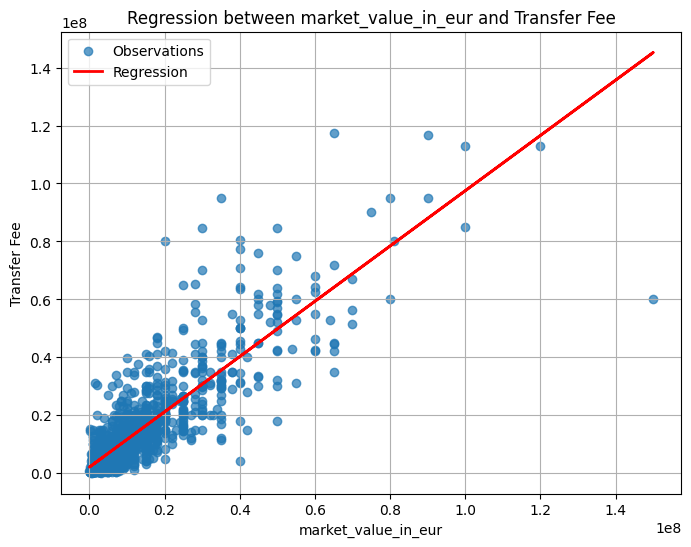

In [30]:
from using_data.ml_models import linear_regression as lr
from using_data.ml_models import plot_regression

na_count_prop = data['market_value_in_eur'].isna().sum() 
print("Nombre de valeurs manquantes dans la colonne 'market_value_in_eur':")
print(na_count_prop)

X = data[['market_value_in_eur']]  # Utiliser des doubles crochets pour obtenir un DataFrame
y = data['transfer_fee']

# Lancer une régression linéaire de 'transfer_fee' en fonction de 'Age' et afficher le résultat
result = lr(X, y)
print(f"Coefficients: {result['coefficients']}")
print(f"Racine carré de l'erreur quadratique moyenne: {sqrt(result['mse_test'])}")
print(f"R2 : {result['r2_test']}")

# Afficher le graphique de la régression
plot_regression(X.values, y.values, result, 'market_value_in_eur', 'Transfer Fee')

La régression obtenue est plutôt intéressante. En effet, toute chose égale par ailleurs, augmenter de 1 la valeur transfermarkt d'un joueur augmente en moyenne de 0.91 la valeur de son transfert. Le modèle explique 81% de la variance dans les valeurs de transferts. Enfin, la racine de l'écart quadratique est de 8 millions, ce qui est relativement satisfaisant au vu de l'écart-type de 'transfer_fee' (16 millions).

Ceci étant fait, intéressons-nous à d'autres variables. Dans un match de football, l'équipe gagnante est celle qui marque le plus de buts. Outre ce truisme, il peut donc être assez cohérent de payer plus cher les joueurs qui contribuent le plus à faire marquer leur équipe. Regardons donc la régression de 'transfer_fee' sur le nombre de buts, de passes décisives moins le nombre de penaltys par 90 minutes.

74
Racine de l'erreur quadratique moyenne: 19532122.378926292
R^2: 0.02206756765664364


c:\Users\rorod\ModelingFootballValue\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


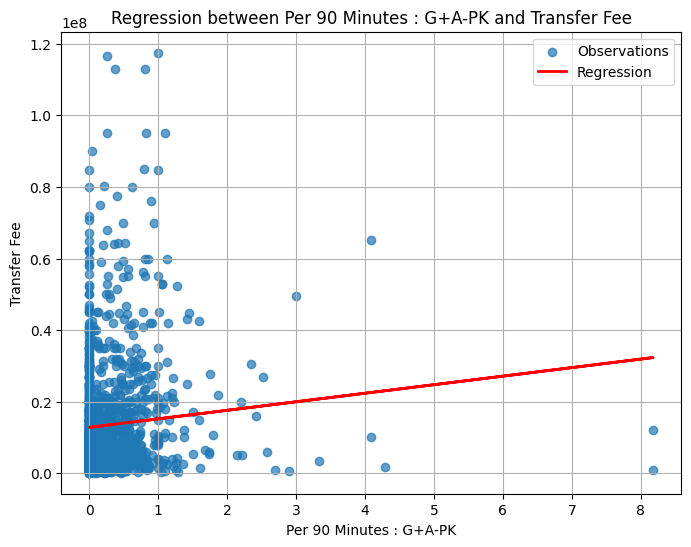

In [31]:
na_count = data['Per 90 Minutes : G+A-PK'].isna().sum() 
print(na_count)

# Comme l'on a que 5% de NA pour la colonne 'Per 90 Minutes : G+A-PK' on peut enlever ces lignes
data = data.dropna(subset=['Per 90 Minutes : G+A-PK'])
na_count_prop = data.isna().sum() 

X = data[['Per 90 Minutes : G+A-PK']]  # Utiliser des doubles crochets pour obtenir un DataFrame
y = data['transfer_fee']

# Lancer une régression linéaire de 'transfer_fee' en fonction de 'Age' et afficher le résultat
result = lr(X, y)
print(f"Racine de l'erreur quadratique moyenne: {sqrt(result['mse_test'])}")
print(f"R^2: {result['r2_test']}")

# Afficher le graphique de la régression
plot_regression(X.values, y.values, result, 'Per 90 Minutes : G+A-PK', 'Transfer Fee')

Malheureusement, les résultats sont loins d'être satisfaisants. Le R2 est de seulement 2% et la racine de l'erreur quadratique moyenne est de 19 millons ce qui signifie que prédire 'transfer_fee' par sa moyenne produit moins d'erreur en moyenne.

Enfin, regardons la régression de 'transfer_fee' sur l'âge.

Racine de l'erreur quadratique moyenne: 19708532.537528343
R^2 (Test): 0.004322820584177101


c:\Users\rorod\ModelingFootballValue\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


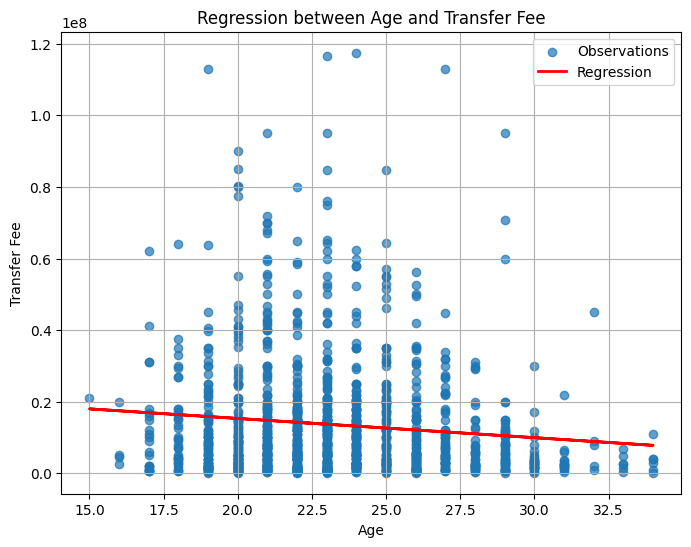

In [32]:
X = data[['Age']]  # Utiliser des doubles crochets pour obtenir un DataFrame
y = data['transfer_fee']

# Lancer une régression linéaire de 'transfer_fee' en fonction de 'Age' et afficher le résultat
result = lr(X, y)
print(f"Racine de l'erreur quadratique moyenne: {sqrt(result['mse_test'])}")
print(f"R^2 (Test): {result['r2_test']}")

# Afficher le graphique de la régression
plot_regression(X.values, y.values, result, 'Age', 'Transfer Fee')

Que ce soit avec la racine l'erreur quadratique moyenne de 19 millions, le R2 de 0,4% ou par lecture graphique, on voit bien que les résultats ne sont pas satisfaisants. Cela peut s'expliquer par le fait qu'il y ait une grande dispersion dans les valeurs de transfert, mais surtout parce que la relation entre les valeurs de transfert et l'âge n'est pas du tout linéaire. Plus un joueur est jeune, plus il a encore du potentiel et vaut donc cher. D'un autre côté, plus il est âgé, plus il est expérimenté et donc potentiellement cher, mais plus il est proche de sa retraite, ce qui peut également diminuer sa valeur.

Tout cela montre, dans notre étude, les limites d'un modèle linéaire et nous pousse à utiliser un modèle plus avancé comme une forêt d'arbres décisionnels.

<a id='random-forest'></a>
### <u>b. Approche plus poussée : Forêt d'arbres décisionnels</u>

Bien que moins bien interprétable qu'une regression linéaire, l'agorithme de forêt d'arbres décisionnels est bien plus adapté pour prédire des relations non linéaires entre les varibales. Il est donc plutôt cohérent d'y avoir recours dans notre étude.

Néanmoins, il faut sélectionner les variables pertinentes pour notre modélisation mais qui contiennent un nombre faible de Na, comme précedemment avec les exemples utilisant des regressions linéaires.


In [33]:
na_count_total = data.isna().sum().to_dict()
print(data.shape)
print("Nombre de valeurs manquantes par colonne dans le DataFrame 'relevant_transfers':")
print(na_count_total)

(1256, 49)
Nombre de valeurs manquantes par colonne dans le DataFrame 'relevant_transfers':
{'Player': 0, 'Season': 0, 'Age': 0, 'Squad': 0, 'Country': 197, 'Comp': 0, 'MP': 71, 'Playing Time : Starts': 0, 'Playing Time : Min': 0, 'Playing Time : 90s': 0, 'Performance : Gls': 0, 'Performance : Ast': 0, 'Performance : G+A': 0, 'Performance : G-PK': 0, 'Performance : PK': 0, 'Performance : PKatt': 0, 'Performance : CrdY': 0, 'Performance : CrdR': 0, 'Expected : xG': 733, 'Expected : npxG': 733, 'Expected : xAG': 733, 'Expected : npxG+xAG': 733, 'Progression : PrgC': 733, 'Progression : PrgP': 733, 'Progression : PrgR': 733, 'Per 90 Minutes : Gls': 0, 'Per 90 Minutes : Ast': 0, 'Per 90 Minutes : G+A': 0, 'Per 90 Minutes : G-PK': 0, 'Per 90 Minutes : G+A-PK': 0, 'Per 90 Minutes : xG': 733, 'Per 90 Minutes : xAG': 733, 'Per 90 Minutes : xG+xAG': 733, 'Per 90 Minutes : npxG': 733, 'Per 90 Minutes : npxG+xAG': 733, 'Matches': 21, 'LgRank': 1244, 'season_id': 0, 'player_id': 0, 'transfer_date'

Sur 1256 lignes, certaines variables comme 'Expected : xG' contiennent 735 Na soit environ 60% des nos données. Elles ne sont donc malheureusement pas exploitable alors même qu'elles auraient pu être pertinentes. Pour les variables 'MP' et 'Matches, elles n'apportent pas plus d'informations que les trois autres variables sur le temps de jeu, on peut donc les enlever.

In [34]:
# Calculer le nombre de valeurs manquantes par colonne
na_count_total = data.isna().sum()

# Sélectionner les colonnes dont le nombre de valeurs manquantes est inférieur à 240
columns_to_keep = na_count_total[na_count_total < 240].index.tolist()
columns_to_keep.remove('MP')
columns_to_keep.remove('Matches')

# Créer un nouveau DataFrame en ne conservant que les colonnes sélectionnées
data_clean = data[columns_to_keep]

Il reste la variable 'Country'. En regardant en détails, on se rend compte que les joueurs qui ont un Na dans la variable 'Country' ne les ont que pour des saisons spécifiques. Ainsi en chercheant parmis le data frame d'origine 'players_stats_top7_df' on peut retrouver le pays de ces joueurs.

In [35]:
# Filtrer les lignes où 'MP' est un NA
mp_na_df = data_clean[data_clean['Country'].isna()]

# Calculer les occurrences de la variable 'Player'
player_occurrences = mp_na_df['Player'].value_counts()
print(player_occurrences.head())

# Pour chaque ligne filtrée, trouver les lignes correspondantes dans players_stats_top7_df
for index, row in mp_na_df.iterrows():
    player = row['Player']
    countries = players_stats_top7_df[players_stats_top7_df['Player'] == player]['Country'].dropna().unique()
    
    # Si des pays non NA sont trouvés, remplacer la valeur NA dans mp_na_df
    if len(countries) > 0:
        data_clean.at[index, 'Country'] = countries[0]  # Remplacer par le premier pays trouvé

# Calculer le nombre de valeurs manquantes par colonne
na_count_total = data_clean.isna().sum().to_dict()
print(na_count_total)

#On enlève les colonnes qui sont de type 'object'
data_clean = data_clean.select_dtypes(exclude=['object'])

# On enlève les colonnes qui contiennent 'id' dans le nom
data_clean = data_clean[[col for col in data_clean.columns if 'id' not in col]]

print(data_clean.columns)

Player
Geoffrey Kondogbia    3
Andros Townsend       2
Cristian Romero       2
Antoine Griezmann     2
Lucas Digne           2
Name: count, dtype: int64
{'Player': 0, 'Season': 0, 'Age': 0, 'Squad': 0, 'Country': 0, 'Comp': 0, 'Playing Time : Starts': 0, 'Playing Time : Min': 0, 'Playing Time : 90s': 0, 'Performance : Gls': 0, 'Performance : Ast': 0, 'Performance : G+A': 0, 'Performance : G-PK': 0, 'Performance : PK': 0, 'Performance : PKatt': 0, 'Performance : CrdY': 0, 'Performance : CrdR': 0, 'Per 90 Minutes : Gls': 0, 'Per 90 Minutes : Ast': 0, 'Per 90 Minutes : G+A': 0, 'Per 90 Minutes : G-PK': 0, 'Per 90 Minutes : G+A-PK': 0, 'season_id': 0, 'player_id': 0, 'transfer_date': 0, 'transfer_season': 0, 'from_club_id': 0, 'to_club_id': 0, 'from_club_name': 0, 'to_club_name': 0, 'transfer_fee': 0, 'market_value_in_eur': 0, 'from_domestic_competition_id': 0, 'to_domestic_competition_id': 0}
Index(['Age', 'Playing Time : Starts', 'Playing Time : Min',
       'Playing Time : 90s', 'Perfor

Finalement, on a bien un data_frame nettoyé (sans aucun Na) sur lequel on peut appliquer notre algorithme.

In [36]:
# Dernière vérification s'il y a des valeurs non numériques
print(data_clean.applymap(lambda x: isinstance(x, (int, float))).all().to_dict())

{'Age': True, 'Playing Time : Starts': True, 'Playing Time : Min': True, 'Playing Time : 90s': True, 'Performance : Gls': True, 'Performance : Ast': True, 'Performance : G+A': True, 'Performance : G-PK': True, 'Performance : PK': True, 'Performance : PKatt': True, 'Performance : CrdY': True, 'Performance : CrdR': True, 'Per 90 Minutes : Gls': True, 'Per 90 Minutes : Ast': True, 'Per 90 Minutes : G+A': True, 'Per 90 Minutes : G-PK': True, 'Per 90 Minutes : G+A-PK': True, 'transfer_fee': True, 'market_value_in_eur': True}


C:\Users\rorod\AppData\Local\Temp\ipykernel_10336\320152474.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(data_clean.applymap(lambda x: isinstance(x, (int, float))).all().to_dict())


Nous utilisons le model RandomForestRegressor de la bibliothèque sklearn.

La racine de l'erreur quadratique moyenne est : 9686548.20899411
Le r2 est de : 0.7594817338230768


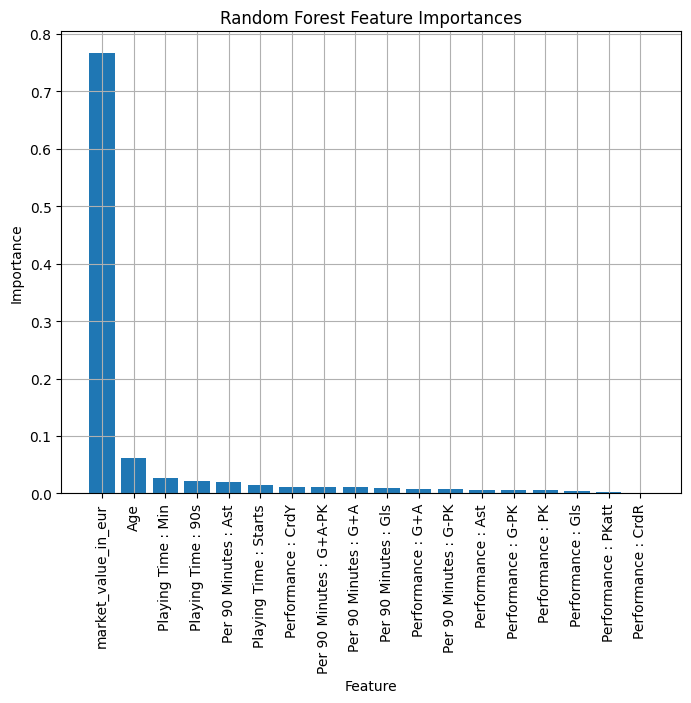

In [37]:
from using_data.ml_models import random_forest_regression as rfr
from using_data.ml_models import plot_rf_feature_importances as rfi

results = rfr(data_clean.drop('transfer_fee', axis = 1), data_clean['transfer_fee'] , n_estimators= 1000)
print("La racine de l'erreur quadratique moyenne est : " + str(sqrt(results['mse_test'])))
print('Le r2 est de : ' + str(results['r2_test']))
rfi(results['feature_importances'], results['feature_names'])

Le coefficient de R2 indique que le modèle explique environ 76% de la variance de la variable cible, ce qui suggère que le modèle capture bien les tendances générales des données. Cependant, la racine de l'erreur quadratique moyenne (REQM) est de 9,7 millions d'euros, ce qui est relativement élevé, signifiant que les prédictions du modèle peuvent être loin des valeurs réelles, indiquant une grande variance dans les erreurs de prédiction. En résumé, bien que le modèle explique bien la variance de la variable cible, les prédictions individuelles présentent des erreurs importantes, suggérant que des améliorations peuvent être apportées pour réduire la variance des erreurs de prédiction. Enfin, la variable qui explique quasiment 80% de nos prédictions est, sans surprise, market_value_eur. Cela est assez cohérent puisque c'est une estimation de celle-ci. Malheureusement, dans notre étude, c'est assez dommageable car elle prend une part trop importante dans le modèle.

<a id='xg-boost'></a>
### <u>c. Modèle final : XGBoost</u>

Le dernier modèle que nous avons tenté d'utiliser et le modèle XGBoost de la bibiliothèque XGBRegressor. C'est un algorithme de machine learning basé sur les arbres de décision, conçu pour optimiser la vitesse et les performances des modèles de gradient boosting. Il utilise des techniques avancées comme la régularisation pour prévenir le surapprentissage et le traitement parallèle pour accélérer l'entraînement. Il est beaucoup utilisé notamment dans les hackathons de machine learning car, en théorie, précis et robuste.

La racine de l'erreur quadratique moyenne est : 9591198.686497465
Le r2 est de : 0.764193511306356


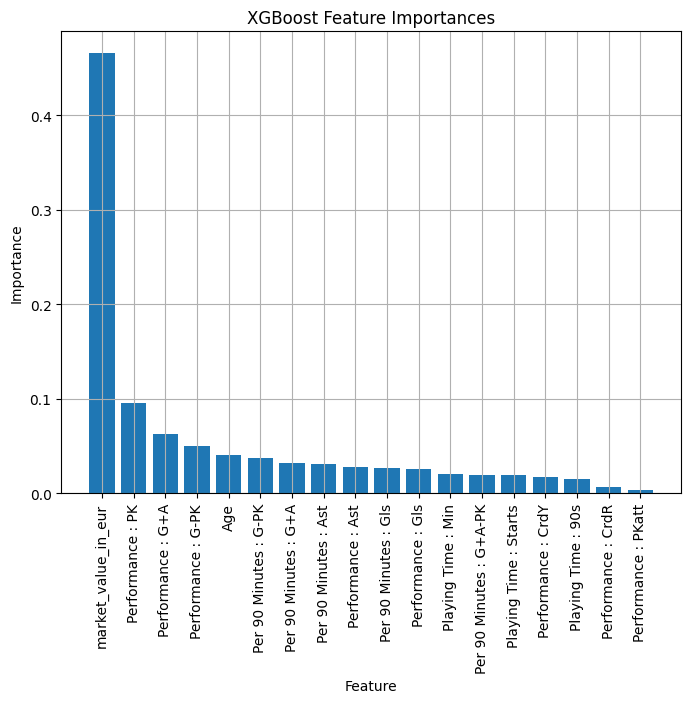

In [38]:
from using_data.ml_models import xgboost_regression as xgb
from using_data.ml_models import plot_xgb_feature_importances as xgfi

results_xgb = xgb(data_clean.drop('transfer_fee', axis = 1), data_clean['transfer_fee'] , n_estimators= 1000, max_depth= 3)
print("La racine de l'erreur quadratique moyenne est : " + str(sqrt(results_xgb['mse_test'])))
print('Le r2 est de : ' + str(results_xgb['r2_test']))
xgfi(results_xgb['feature_importances'], results_xgb['feature_names'])

Grâce au modèle XGBoost, on améliore le R2 de 0.05, on réduit la racine de l'écart quadratique de quasi 100 000 euros et market_value_eur n'est pas la seule variable importante bien qu'elle prédise quasi 40% de nos résultats. D'autres variables comme le nombre de buts et de passes décisives, l'âge ou encore le temps de jeu permettent de prédire la future valeur d'un joueur.

Finalement, le modèle est plus satisfaisant que les précédents, expliquant plutôt bien la variance de nos prédictions. Néanmoins, la variable que nous tentons de prédire a un écart-type de 16 millions, ce qui explique que l'écart quadratique soit si élevé.